In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
data=pd.read_csv("drive/MyDrive/Colab Notebooks/Data/labels.csv")
data.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
filename=["/content/drive/MyDrive/Colab Notebooks/Data/train/"+i+".jpg" for i in data.id]
len(filename)

10222

In [ ]:
breed=data.breed.to_numpy()
unique_breed=np.unique(breed)
# unique_label=[label==unique_breed for label in breed]
unique_breed

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
SAMPLE_SIZE=1000 #@param{type:"slider",min:1000,max:10000,step:1000}

In [ ]:
X=filename
y=unique_label

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X[:SAMPLE_SIZE],y[:SAMPLE_SIZE])

In [ ]:
def process(imagepath):
  image = tf.io.read_file(imagepath)
  image = tf.io.decode_jpeg(image,channels=3)
  image = tf.image.convert_image_dtype(image,tf.float32) 
  image = tf.image.resize(image,size=[224,224])
  return image
def get_image_process(imagepath,label):
  path=process(imagepath)
  return path,label
BATCH_SIZE=32
def create_batch(x,y=None,batch_size=BATCH_SIZE,valid=False,test=False):
  if test:
    print("Test data is begin to be converted to batches...")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x)))
    data_batch=data.map(process).batch(batch_size)
    return data_batch
  elif valid:
    print("valid data is begin to converted to batches...")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
    data_batch=data.map(get_image_process).batch(batch_size)
    return data_batch
  else:
    print("Train Data is begin to converted to batches...")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
    data=data.shuffle(buffer_size=(len(x)))
    data=data.map(get_image_process)
    data_batch=data.batch(batch_size)
    return data_batch

In [ ]:
train_data=create_batch(X_train,y_train)
valid_data=create_batch(X_test,y_test,valid=True)

Train Data is begin to converted to batches...
valid data is begin to converted to batches...


In [ ]:
import matplotlib.pyplot as plt
def display_25_image(images,label):
  plt.figure(figsize=(10,10))
  for i in range(25):
    ax=plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.title(unique_breed[label[i].argmax()])
    plt.axis("off")


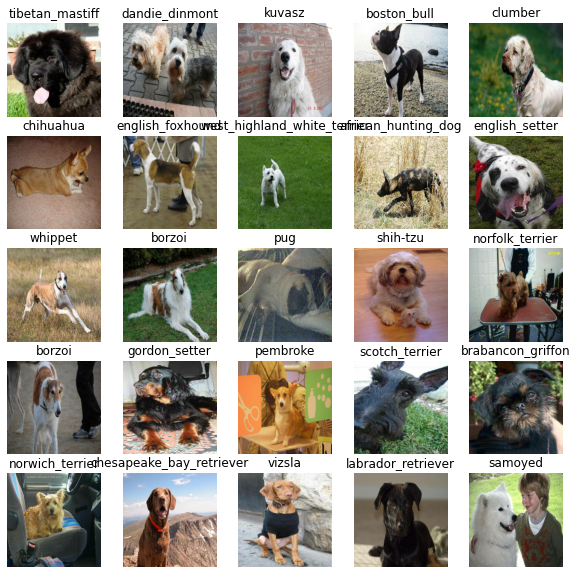

In [ ]:
train_image,train_label=next(train_data.as_numpy_iterator())
train_image,train_label
display_25_image(train_image,train_label)

In [ ]:
image_size=224
INPUT_SHAPE=[None,image_size,image_size,3]
OUTPUT_SHAPE=len(unique_breed)
MODEL_URL="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [ ]:
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
  print("Building Model with: ",MODEL_URL)
  model=tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL),
      tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax")
  ])
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )
  model.build(INPUT_SHAPE)
  return model

In [ ]:
model=create_model()
model.summary()

Building Model with:  https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 120)               153720    
                                                                 
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
def create_tensorboard_callback():
  logdir= os.path.join("drive/MyDrive/Colab Notebooks/logs",
                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)


In [ ]:
NUM_EPOCS=100 #@param{type:"slider",min:10,max:100,step:10}

In [ ]:
%load_ext tensorboard
import os 
import datetime

In [ ]:
def train_model():
  model=create_model()
  tensorboard=create_tensorboard_callback()
  model.fit(
      x=train_data,
      epochs=NUM_EPOCS,
      validation_data=valid_data,
      validation_freq=1,
      callbacks=[tensorboard,early_stopping]
  )
  return model

In [ ]:
model=train_model()

Building Model with:  https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Epoch 1/10
24/24 [==============================] - 400s 17s/step - loss: 4.3643 - accuracy: 0.1067 - val_loss: 3.2792 - val_accuracy: 0.2720
Epoch 2/10
24/24 [==============================] - 4s 152ms/step - loss: 1.8006 - accuracy: 0.7187 - val_loss: 2.1088 - val_accuracy: 0.5080
Epoch 3/10
24/24 [==============================] - 4s 156ms/step - loss: 0.7496 - accuracy: 0.9360 - val_loss: 1.6303 - val_accuracy: 0.5840
Epoch 4/10
24/24 [==============================] - 3s 132ms/step - loss: 0.3799 - accuracy: 0.9867 - val_loss: 1.4675 - val_accuracy: 0.6040
Epoch 5/10
24/24 [==============================] - 4s 155ms/step - loss: 0.2386 - accuracy: 0.9960 - val_loss: 1.3685 - val_accuracy: 0.6240
Epoch 6/10
24/24 [==============================] - 3s 135ms/step - loss: 0.1662 - accuracy: 1.0000 - val_loss: 1.3176 - val_accuracy: 0.6120
Epoch 7/10
24/24 [==============================] - 4s 155m

In [ ]:
predictions= model.predict(valid_data,verbose=1)
predictions

8/8 [==============================] - 1s 104ms/step


array([[7.4226395e-05, 1.0887899e-03, 1.8245504e-05, ..., 1.3160468e-05,
        3.4535055e-06, 9.0695202e-04],
       [2.3097225e-04, 8.8965404e-05, 1.5506781e-05, ..., 4.1472937e-05,
        4.6499250e-03, 2.4294304e-02],
       [8.4213779e-04, 9.2415263e-05, 3.1591658e-03, ..., 2.1492529e-05,
        2.2663289e-06, 8.2342792e-04],
       ...,
       [2.6420975e-02, 1.8843701e-02, 6.3274981e-04, ..., 4.6202666e-04,
        4.7758681e-06, 2.0789681e-03],
       [1.7274057e-05, 9.6512536e-05, 2.3088376e-03, ..., 1.6269935e-02,
        1.2464121e-03, 3.3940664e-03],
       [2.6800737e-04, 5.7499105e-04, 5.5905944e-05, ..., 4.1878408e-05,
        4.3602527e-06, 1.5933871e-03]], dtype=float32)

In [ ]:
def get_preds_label(predictions):
  return unique_breed[predictions.argmax()]

In [ ]:
def unbatchify(data):
  images=[]
  labels=[]
  for image,label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breed[label.argmax()])
  return images,labels

In [ ]:
val_images,val_labels=unbatchify(valid_data)
val_labels[0]

'golden_retriever'

In [ ]:
def plot_pred(predictions_probs,labels,images,n=1):
  preds_prob,true_label,image=predictions_probs[n],labels[n],images[n]
  preds_label=get_preds_label(preds_prob)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  if preds_label==true_label:
    color="green"
  else:
    color="red"
  plt.title("{} {:2.0f}% {}".format(preds_label,np.max(preds_prob)*100,true_label),color=color)

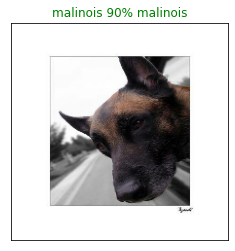

In [ ]:
plot_pred(predictions,val_labels,val_images,5)

In [ ]:
full_data=create_batch(X,y)

Train Data is begin to converted to batches...


In [ ]:
full_model=create_model()

Building Model with:  https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4


In [ ]:
full_model_tensorboard=create_tensorboard_callback()
full_model_early_stopping=tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=3)

In [ ]:
full_model.fit(x=full_data,epochs=NUM_EPOCS,callbacks=[full_model_tensorboard,full_model_early_stopping])

Epoch 1/10
320/320 [==============================] - 3313s 10s/step - loss: 1.2848 - accuracy: 0.6851
Epoch 2/10
320/320 [==============================] - 31s 95ms/step - loss: 0.4079 - accuracy: 0.8821
Epoch 3/10
320/320 [==============================] - 31s 96ms/step - loss: 0.2546 - accuracy: 0.9366
Epoch 4/10
320/320 [==============================] - 31s 96ms/step - loss: 0.1742 - accuracy: 0.9639
Epoch 5/10
320/320 [==============================] - 30s 95ms/step - loss: 0.1222 - accuracy: 0.9798
Epoch 6/10
320/320 [==============================] - 31s 96ms/step - loss: 0.0900 - accuracy: 0.9882
Epoch 7/10
320/320 [==============================] - 30s 95ms/step - loss: 0.0688 - accuracy: 0.9933
Epoch 8/10
320/320 [==============================] - 34s 106ms/step - loss: 0.0534 - accuracy: 0.9959
Epoch 9/10
320/320 [==============================] - 31s 97ms/step - loss: 0.0429 - accuracy: 0.9977
Epoch 10/10
320/320 [==============================] - 30s 95ms/step - loss: 0.0

In [ ]:
def save_model(model,suffix):
  modeldir=os.path.join("/content/drive/MyDrive/Colab Notebooks/model",datetime.datetime.now().strftime("%Y%m%d-%H%Ms"))
  model_path=modeldir+"-"+suffix+".h5"
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
save_model(full_model,suffix="final_model")

Saving model to: /content/drive/MyDrive/Colab Notebooks/model/20221024-0825s-final_model.h5...


In [ ]:
custom_path="/content/drive/MyDrive/test/"
custom_image_path=[custom_path+i for i in os.listdir(custom_path)]
custom_image_path

['/content/drive/MyDrive/test/a.jpeg', '/content/drive/MyDrive/test/b.jpeg']

In [ ]:
custom_data=create_batch(custom_image_path,test=True)
custom_data

Test data is begin to be converted to batches...


<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [ ]:
custom_preds=full_model.predict(custom_data)

1/1 [==============================] - 1s 1s/step


In [ ]:
custom_preds.shape

(2, 120)

In [ ]:
custom_pred_label=[get_preds_label(custom_preds[1]),get_preds_label(custom_preds[0])]
custom_pred_label

['pug', 'pug']

In [ ]:
custom_image=[]
for image in custom_data.unbatch().as_numpy_iterator():
  custom_image.append(image)

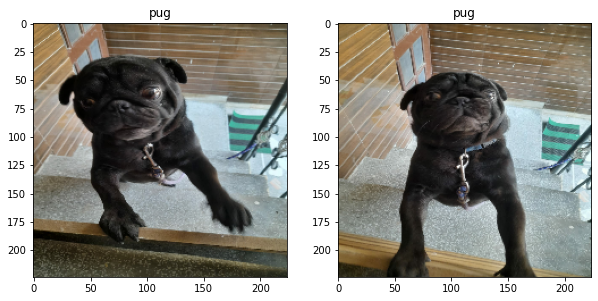

In [ ]:
plt.figure(figsize=(10,10))
for i,image in enumerate(custom_image):
  plt.subplot(1,2,i+1)
  plt.title(custom_pred_label[i])
  plt.imshow(image)
